In [1]:
import sys
sys.path.append('/Users/ianleefmans/Desktop/stock-sentiment/utils')
from data import Database, ScrapeWSB, Stock
from datahelper import PostDataset, CommentDataset, get_indices
from torch.utils.data import DataLoader
from inference import RunInference
from models import FineTuneBaseModel, FineTuneClassifier
%cd /Users/ianleefmans/Desktop/stock-sentiment

/Users/ianleefmans/Desktop/stock-sentiment


In [2]:
import transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:

db = Database()
db.use_database('DB1')

print(db.query('show tables;'))

connection established
[(datetime.datetime(2021, 6, 14, 14, 31, 50),)]
[('COMMENTS',), ('POSTS',), ('STOCKS',)]


In [7]:
print(len(db.query("SELECT COMMENT_ID FROM COMMENTS WHERE TARGET IN (0,1)")))

505


In [8]:
len(db.query('''SELECT TITLE, TARGET FROM POSTS WHERE TARGET IN (0,1);'''))

38

In [8]:
len(db.query('''SELECT COMMENT, TARGET FROM COMMENTS WHERE TARGET IN (0,1);'''))

203

In [7]:
db.query("SELECT * FROM STOCKS WHERE STOCK_ID='AMC' AND LAST_SCRAPED >= DATE_SUB(NOW(),INTERVAL 55 MINUTE)")

[('AMC', datetime.datetime(2021, 6, 6, 22, 15, 44))]

In [16]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'), INTERVAL {} HOUR);".format('BB', 'BB', 6))



[('nx2ihx',),
 ('nxcb5h',),
 ('nxp5r6',),
 ('nxtjj4',),
 ('nxv9jr',),
 ('nxx9sz',),
 ('ny01wx',),
 ('nz6tgd',),
 ('nzf0mj',),
 ('nzjcfg',)]

In [12]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'),INTERVAL {} HOUR);".format('BB','BB',6))



[('nx2ihx',),
 ('nxcb5h',),
 ('nxp5r6',),
 ('nxtjj4',),
 ('nxv9jr',),
 ('nxx9sz',),
 ('ny01wx',),
 ('nz6tgd',),
 ('nzf0mj',),
 ('nzjcfg',)]

In [4]:
db.query("SELECT LAST_SCRAPED FROM POSTS WHERE LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = 'GME'),INTERVAL 6 HOUR);")
         
         
         


[(datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 2),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40, 1),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 40),),
 (datetime.datetime(2021, 6, 7, 1, 39, 59),),
 (datetime.datetime(2021, 6

In [11]:
db.query("SELECT LAST_SCRAPED FROM POSTS")

[(datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 2),),
 (datetime.datetime(2021, 6, 6, 17, 24, 1),),
 (datetime.datetime(2021, 6, 6, 17, 24, 1),),
 (datetime.datetime(2021, 6, 6, 17, 24, 1),)]

In [45]:
indices = db.query("SELECT POST_ID FROM POSTS WHERE StOCK_ID='{}';".format("GME"))

In [4]:
db = Database()
db.use_database('DB1')
#db.drop_table("LABELED_POSTS")
#db.drop_table("LABELED_COMMENTS")

db.initialize_tables()

scrapewsb = ScrapeWSB('GME', 11, 2)

df = scrapewsb.scrape()
scrapewsb.convert(df)
print("DONE")

connection established
[(datetime.datetime(2021, 6, 6, 17, 23, 59),)]
connection established
[(datetime.datetime(2021, 6, 6, 17, 24),)]


  0%|          | 0/11 [00:00<?, ?it/s]

connection established
[(datetime.datetime(2021, 6, 6, 17, 24, 3),)]


100%|██████████| 11/11 [01:08<00:00,  6.24s/it]

DONE


In [4]:
db = Database()
db.use_database('DB1')

connection established
[(datetime.datetime(2021, 5, 30, 0, 20, 6),)]


In [3]:
db.drop_table('COMMENTS')
db.drop_table("POSTS")
db.drop_table("STOCKS")

In [2]:
indices = get_indices("BB")

connection established
[(datetime.datetime(2021, 6, 14, 16, 40, 42),)]


In [3]:
post_train = PostDataset(512, indices['post_train'])



In [4]:
post_trainloader = DataLoader(
    dataset=post_train, 
    batch_size=3, 
    num_workers=0,
    shuffle=True
    )

In [5]:
sample = iter(post_trainloader).next()

connection established
[(datetime.datetime(2021, 6, 14, 16, 40, 44),)]


/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


connection established
[(datetime.datetime(2021, 6, 14, 16, 40, 44),)]
connection established
[(datetime.datetime(2021, 6, 14, 16, 40, 45),)]


In [6]:
sample


{'post': ['TD Ameritrade has added AMC to the restricted securities list',
  'AMC ends dizzying week with more wild moves',
  'First ever gains post.. GME and AMC to the moon we hodl 🦍💎🙌🚀🌝'],
 'post_input_ids': tensor([[  101, 15439,  7277,  ...,     0,     0,     0],
         [  101, 24810,  3769,  ...,     0,     0,     0],
         [  101,  1752,  1518,  ...,     0,     0,     0]]),
 'post_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([0, 0, 1])}

In [7]:
model = FineTuneClassifier()

out = model(input_ids=sample['post_input_ids'], attention_masks=sample['post_attention_mask'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [10]:
out

tensor([[0.3778, 0.6222],
        [0.3432, 0.6568],
        [0.3604, 0.6396]], grad_fn=<SoftmaxBackward>)

In [8]:
model = FineTuneClassifier()
out = model(input_ids=sample['post_input_ids'], attention_masks=sample['post_attention_mask'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [9]:
out

SequenceClassifierOutput(loss=None, logits=tensor([[0.2113, 0.7564],
        [0.1775, 0.7651],
        [0.2064, 0.8715]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [2]:
run_inference = RunInference(stock_id='BB')
inference_output = run_inference.evaluate()

post_probs = inference_output['avg_post_probs']

comment_probs = inference_output['avg_comment_probs']

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 30),)]


Determining Sentiment From Posts:   0%|          | 0/1 [00:00<?, ?it/s]

connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 32),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 33),)]


/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 33),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 34),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 34),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 35),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 35),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 36),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 36),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 37),)]
connection established
[(datetime.datetime(2021, 6, 14, 17, 1, 37),)]


Determining Sentiment From Comments: 100%|██████████| 2/2 [01:39<00:00, 49.56s/it]


In [3]:
post_probs

tensor([0.7672, 0.2328])

In [4]:
comment_probs

tensor([0.7638, 0.2362])

In [5]:
all_post_probs = inference_output['all_post_probs']
all_comment_probs = inference_output['all_comment_probs']

In [11]:
all_post_probs

tensor([[0.7791, 0.2209],
        [0.7635, 0.2365],
        [0.7730, 0.2270],
        [0.7626, 0.2374],
        [0.7716, 0.2284],
        [0.7655, 0.2345],
        [0.7509, 0.2491],
        [0.7704, 0.2296],
        [0.7654, 0.2346],
        [0.7704, 0.2296]])

In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns




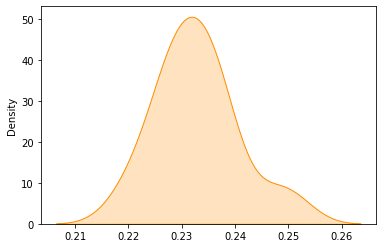

In [46]:
ser = pd.Series(all_post_probs[:,1])

sns.kdeplot(ser, color="darkorange", shade=True);
# df = ser.to_frame()
# df.rename(columns={0:'post_probs'}, inplace=True)
# df.reset_index(inplace=True)
#df.plot.scatter(x='index', y=0)

In [7]:
all_comment_probs

tensor([[0.7604, 0.2396],
        [0.7518, 0.2482],
        [0.7723, 0.2277],
        [0.7716, 0.2284],
        [0.7508, 0.2492],
        [0.7618, 0.2382],
        [0.7722, 0.2278],
        [0.7670, 0.2330],
        [0.7587, 0.2413],
        [0.7611, 0.2389],
        [0.7651, 0.2349],
        [0.7816, 0.2184],
        [0.7610, 0.2390],
        [0.7634, 0.2366],
        [0.7697, 0.2303],
        [0.7680, 0.2320],
        [0.7722, 0.2278],
        [0.7743, 0.2257],
        [0.7654, 0.2346],
        [0.7648, 0.2352],
        [0.7728, 0.2272],
        [0.7570, 0.2430],
        [0.7581, 0.2419],
        [0.7626, 0.2374],
        [0.7695, 0.2305],
        [0.7559, 0.2441],
        [0.7705, 0.2295],
        [0.7588, 0.2412],
        [0.7704, 0.2296],
        [0.7501, 0.2499],
        [0.7649, 0.2351],
        [0.7705, 0.2295],
        [0.7688, 0.2312],
        [0.7670, 0.2330],
        [0.7519, 0.2481],
        [0.7464, 0.2536],
        [0.7651, 0.2349],
        [0.7705, 0.2295],
        [0.7

In [26]:
import torch
torch.cat((out,out), dim=0).size()

torch.Size([6, 2])

In [22]:
out.size()

torch.Size([3, 2])